# 1. 线性回归（简化模型）

![](Learn_Pictures/05-线性回归+基础优化算法/img.png)

![](Learn_Pictures/05-线性回归+基础优化算法/img_1.png)

# 2. 神经网络

![](Learn_Pictures/05-线性回归+基础优化算法/img_2.png)

![](Learn_Pictures/05-线性回归+基础优化算法/img_3.png)

# 3. 线性回归（求最优解）

![](Learn_Pictures/05-线性回归+基础优化算法/img_4.png)
![](Learn_Pictures/05-线性回归+基础优化算法/img_5.png)
![](Learn_Pictures/05-线性回归+基础优化算法/img_6.png)
![](Learn_Pictures/05-线性回归+基础优化算法/img_7.png)

# 4. 线性回归（总结）

![](Learn_Pictures/05-线性回归+基础优化算法/img_8.png)

# 5. 优化方法
## 5.1 梯度下降法

![](Learn_Pictures/05-线性回归+基础优化算法/img_9.png)
![](Learn_Pictures/05-线性回归+基础优化算法/img_10.png)
![](Learn_Pictures/05-线性回归+基础优化算法/img_11.png)

## 5.2 小批量随即梯度下降法

![](Learn_Pictures/05-线性回归+基础优化算法/img_12.png)

## 5.3 选择批量大小

![](Learn_Pictures/05-线性回归+基础优化算法/img_13.png)

## 5.4 总结

![](Learn_Pictures/05-线性回归+基础优化算法/img_14.png)
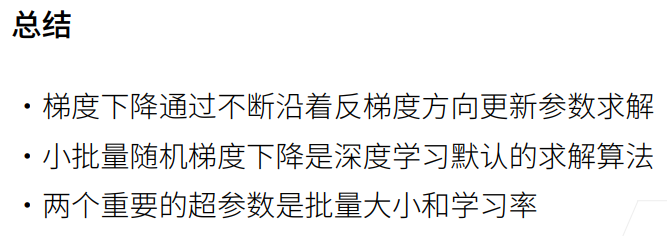

# 6. 线性回归（使用自定义）
将从零开始实现整个方法，包括数据流水线、模型、损失函数和小批量随即梯度下降优化器。
## 6.1 生成数据集
根据带有噪声的线性模型构造一个人造数据集。我们使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$和噪声项ϵ生成数据集及其标签：$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon$。

In [18]:
from win32con import TC_OP_CHARACTER
# 在 Jupyter Notebook 中配置 matplotlib 使其内联显示图表（图表直接嵌入在单元格输出中）
%matplotlib inline

# 导入必要的库
import random           # 用于随机操作
import torch            # PyTorch 深度学习框架
from d2l import torch as d2l  # Dive into Deep Learning (d2l) 库的 PyTorch 实现，提供实用工具函数

def synthetic_data(w, b, num_examples):
    """
    生成一个合成的线性回归数据集：y = Xw + b + 噪声

    参数:
    w (torch.Tensor): 真实的权重向量 (维度为 [n])
    b (float): 真实的偏置项
    num_examples (int): 要生成的数据样本数量

    返回:
    x (torch.Tensor): 特征矩阵 (维度为 [num_examples, len(w)])
    y (torch.Tensor): 标签向量 (维度为 [num_examples, 1])
    """
    # 生成特征矩阵 x：从标准正态分布采样，形状为 [num_examples, len(w)]
    x = torch.normal(0, 1, (num_examples, len(w)))

    # 计算标签 y = x * w + b，使用矩阵乘法
    y = torch.matmul(x, w) + b

    # 添加高斯噪声：均值为0，标准差为0.01，形状与 y 相同
    y += torch.normal(0, 0.01, y.shape)

    # 将 y 重塑为列向量 [num_examples, 1] 并返回 x 和 y
    return x, y.reshape((-1, 1))

# 定义真实的模型参数
true_w = torch.tensor([2, -3.4])  # 权重向量 [w1, w2]
true_b = -4.2                     # 偏置项

# 生成1000个样本的合成数据集
features, labels = synthetic_data(true_w, true_b, 1000)

# 打印特征矩阵和标签向量的形状
print("features.shape:", features.shape)  # 输出: torch.Size([1000, 2])
print("labels.shape:", labels.shape)      # 输出: torch.Size([1000, 1])

features.shape: torch.Size([1000, 2])
labels.shape: torch.Size([1000, 1])


## 6.2 绘制数据集
    features中每一行都包含一个二维数据样本，labels中的每一行都包含一维标签值（一个标签）。

features: tensor([-0.3727,  1.1086])
labels: tensor([-8.6986])


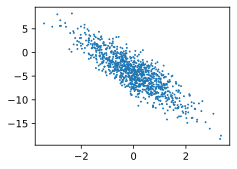

In [19]:
# 打印第一个样本的特征和标签值
print('features:', features[0])  # 输出第一个样本的特征值 (2个特征)
print('labels:', labels[0])      # 输出第一个样本的标签值

# 设置图表大小（来自d2l库的实用函数）
d2l.set_figsize()

# 创建散点图：显示第二个特征与标签的关系
# 参数说明：
#   features[:, 1]: 取所有样本的第二个特征 (x₂)
#   detach().numpy(): 从计算图中分离并转为NumPy数组（matplotlib需要）
#   1: 散点的大小为1
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)


## 6.3 读取小批量

In [20]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

def synthetic_data(w,b,num_exaples):
    """生成 y = Xw + b + 噪声"""
    X = torch.normal(0,1,(num_exaples,len(w)))
    y = torch.matmul(X,w) + b
    y += torch.normal(0,0.01,y.shape)
    return X, y.reshape((-1,1))

true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features:',features[0],'\nlabel:',labels[0])

d2l.set_figsize()
# d2l.plt.scatter(features[:,(1)].detach().numpy(),labels.detach().numpy(),1)


# 定义一个数据迭代器函数，用于生成小批量数据
def data_iter(batch_size, features, labels):
    """
    参数:
    batch_size (int): 每批数据的样本数量
    features (torch.Tensor): 特征矩阵 (形状: [样本数, 特征数])
    labels (torch.Tensor): 标签向量 (形状: [样本数, 1])

    功能:
    将数据集随机打乱顺序后，分批生成小批量数据
    """

    # 获取数据集的样本数量
    num_examples = len(features)  # len(features) 返回样本行数

    # 创建样本索引列表 [0, 1, 2, ..., num_examples-1]
    indices = list(range(num_examples))

    # 随机打乱索引顺序 - 确保每个epoch遍历数据的顺序不同
    # 这对机器学习训练很重要，避免模型记忆样本顺序
    random.shuffle(indices)

    # 循环遍历整个数据集，每次前进batch_size个样本
    for i in range(0, num_examples, batch_size):
        # 计算当前批次的结束位置（避免超出索引范围）
        end_idx = min(i + batch_size, num_examples)

        # 获取当前批次的索引切片
        batch_indices = indices[i:end_idx]

        # 将列表转为PyTorch张量（这步是可选的，有时直接用列表索引也可以）
        batch_indices = torch.tensor(batch_indices)

        # 使用生成器yield返回当前批次的特征和标签
        # yield 使该函数成为生成器，每次迭代时返回一个批次的数据
        yield features[batch_indices], labels[batch_indices]

# 设置批量大小
batch_size = 10

# 使用数据迭代器获取第一个小批量数据
for X, y in data_iter(batch_size, features, labels):
    # 打印当前批次的特征 (10个样本，每个样本有2个特征)
    print('特征矩阵 X:')
    print(X)

    # 打印当前批次对应的标签 (10个样本的标签)
    print('\n标签向量 y:')
    print(y)

    # 只需要第一个批次，完成后立即跳出循环
    break

features: tensor([-0.7114, -0.7071]) 
label: tensor([5.1698])
特征矩阵 X:
tensor([[ 0.2475,  0.1496],
        [ 0.2283,  1.3890],
        [-0.8384,  0.0449],
        [-0.6969, -0.5809],
        [-0.5755,  0.4319],
        [-0.2546,  0.2079],
        [ 1.0597,  1.3574],
        [-0.1163, -0.9563],
        [ 1.4145, -0.1324],
        [-0.7381,  1.0341]])

标签向量 y:
tensor([[ 4.1774],
        [-0.0824],
        [ 2.3741],
        [ 4.7816],
        [ 1.5862],
        [ 2.9812],
        [ 1.6936],
        [ 7.2038],
        [ 7.4869],
        [-0.7862]])


## 6.4 完整模型

features: tensor([-1.3555,  0.2185]) 
label: tensor([0.7308])
Batch Features:
tensor([[ 0.1689, -0.3533],
        [-2.4866,  0.2434],
        [ 0.1918, -0.5336],
        [ 0.6232, -0.1720],
        [ 0.9243, -0.6334],
        [-1.9925, -0.3409],
        [ 0.7604, -0.0463],
        [-1.2338, -1.0180],
        [ 0.9138, -1.1220],
        [-0.2792, -0.9584]])

Batch Labels:
tensor([[ 5.7256],
        [-1.5997],
        [ 6.3751],
        [ 6.0340],
        [ 8.1981],
        [ 1.3858],
        [ 5.8777],
        [ 5.1836],
        [ 9.8343],
        [ 6.9042]])
epoch 1, loss 0.045794
epoch 2, loss 0.000190
epoch 3, loss 0.000047

w的估计误差：tensor([-0.0002, -0.0008], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0009], grad_fn=<RsubBackward1>)


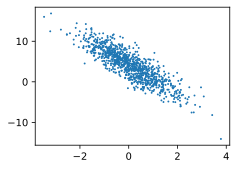

In [21]:
# 在 Jupyter Notebook 中配置 matplotlib 使其内联显示图表
%matplotlib inline

# 导入必要的库
import random  # 用于随机操作
import torch   # PyTorch 深度学习框架
from d2l import torch as d2l  # Dive into Deep Learning (d2l) 库，提供实用函数

def synthetic_data(w, b, num_examples):
    """
    生成一个合成的线性回归数据集：y = Xw + b + 噪声

    参数:
    w (torch.Tensor): 真实的权重向量 (维度为 [n])
    b (float): 真实的偏置项
    num_examples (int): 要生成的数据样本数量

    返回:
    X (torch.Tensor): 特征矩阵 (维度为 [num_examples, len(w)])
    y (torch.Tensor): 标签向量 (维度为 [num_examples, 1])
    """
    # 生成特征矩阵 X：从标准正态分布采样
    X = torch.normal(0, 1, (num_examples, len(w)))

    # 计算标签 y = X * w + b，使用矩阵乘法
    y = torch.matmul(X, w) + b

    # 添加高斯噪声：均值为0，标准差为0.01，形状与 y 相同
    y += torch.normal(0, 0.01, y.shape)

    # 将 y 重塑为列向量 [num_examples, 1] 并返回 X 和 y
    return X, y.reshape((-1, 1))

# 定义真实的模型参数
true_w = torch.tensor([2, -3.4])  # 权重向量 [w1, w2]
true_b = 4.2                      # 偏置项

# 生成1000个样本的合成数据集
features, labels = synthetic_data(true_w, true_b, 1000)

# 打印第一个样本的特征和标签值
print('features:', features[0], '\nlabel:', labels[0])

# 设置绘图尺寸
d2l.set_figsize()

# 创建散点图：显示第二个特征与标签的关系
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

def data_iter(batch_size, features, labels):
    """
    数据迭代器：分批生成随机小批量数据

    参数:
    batch_size (int): 每批数据大小
    features (torch.Tensor): 特征矩阵
    labels (torch.Tensor): 标签向量

    返回:
    生成器: 每次迭代返回 (X_batch, y_batch)
    """
    num_examples = len(features)  # 样本数量
    indices = list(range(num_examples))  # 样本索引列表
    random.shuffle(indices)  # 随机打乱索引顺序

    # 遍历整个数据集，每次获取一个批次
    for i in range(0, num_examples, batch_size):
        # 获取当前批次的索引(确保不越界)
        batch_indices = indices[i:min(i + batch_size, num_examples)]
        # 转换为张量
        batch_indices = torch.tensor(batch_indices)
        # 返回当前批次的特征和标签
        yield features[batch_indices], labels[batch_indices]

# 设置批量大小
batch_size = 10

# 获取并打印第一个小批量数据
for X, y in data_iter(batch_size, features, labels):
    print('Batch Features:')
    print(X)
    print('\nBatch Labels:')
    print(y)
    break  # 只查看第一个批次

# 初始化模型参数
# w: 从正态分布初始化权重，设置requires_grad=True以便自动计算梯度
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
# b: 初始化为0，同样设置requires_grad=True
b = torch.zeros(1, requires_grad=True)

def linreg(X, w, b):
    """线性回归模型: y_hat = Xw + b"""
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):
    """
    均方损失函数

    参数:
    y_hat (torch.Tensor): 预测值
    y (torch.Tensor): 真实值

    返回:
    torch.Tensor: 每个样本的损失
    """
    # 调整y的形状使其与预测值y_hat匹配
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

def sgd(params, lr, batch_size):
    """
    小批量随机梯度下降优化算法

    参数:
    params (list): 需要优化的参数列表
    lr (float): 学习率
    batch_size (int): 批量大小
    """
    with torch.no_grad():  # 禁用梯度计算，节省内存
        for param in params:
            # 参数更新: param = param - lr * (gradient / batch_size)
            # 除以batch_size是为了考虑批量平均损失
            param -= lr * param.grad / batch_size
            # 清除当前参数的梯度
            param.grad.zero_()

# 设置训练超参数
lr = 0.03  # 学习率
num_epochs = 3  # 训练轮数(遍历整个数据集的次数)

# 选择模型和损失函数
net = linreg  # 使用线性回归模型
loss = squared_loss  # 使用均方误差损失

# 训练循环
for epoch in range(num_epochs):
    # 小批量迭代训练
    for X, y in data_iter(batch_size, features, labels):
        # 计算预测值
        y_hat = net(X, w, b)
        # 计算损失
        l = loss(y_hat, y)
        # 计算梯度：对损失求和然后反向传播
        l.sum().backward()
        # 使用梯度更新参数
        sgd([w, b], lr, batch_size)

    # 在每个epoch结束后评估整个数据集的损失
    with torch.no_grad():  # 禁用梯度计算
        # 对整个数据集进行预测
        y_hat_full = net(features, w, b)
        # 计算整个数据集的损失
        train_l = loss(y_hat_full, labels)
        # 打印当前epoch的损失(平均损失)
        print(f'epoch {epoch+1}, loss {float(train_l.mean()):f}')

# 训练完成后，比较真实参数和训练得到的参数
print(f'\nw的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

# 7. 线性回归（使用框架）

In [22]:
# 导入必要的库
import numpy as np
import torch
from torch.utils import data  # PyTorch的数据处理工具
from d2l import torch as d2l  # Dive into Deep Learning工具库

# 真实参数设置（与之前相同）
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w,true_b,1000) # 库函数生成人工数据集

def load_array(data_arrays, batch_size, is_train=True):
    """
    构造一个PyTorch数据迭代器

    参数:
    data_arrays (tuple): 包含特征和标签的张量元组
    batch_size (int): 批大小
    is_train (bool): 是否打乱数据(默认为True)

    返回:
    DataLoader: PyTorch数据加载器
    """
    # 创建TensorDataset对象：包装特征和标签张量
    dataset = data.TensorDataset(*data_arrays)
    # 创建DataLoader：提供批量数据加载功能
    # shuffle=is_train 表示如果是训练则打乱数据
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

# 设置批大小并创建数据迭代器
batch_size = 10
data_iter = load_array((features, labels), batch_size)

# 测试数据迭代器：获取第一个批次
# iter(data_iter) 创建迭代器，next()获取第一个元素
print(next(iter(data_iter)))

# 从PyTorch的神经网络模块导入必要组件
from torch import nn

# 使用顺序容器定义网络结构
# nn.Linear(2,1) 表示线性层：输入特征维度为2，输出特征维度为1
net = nn.Sequential(nn.Linear(2, 1))

# 初始化模型参数
# 权重参数：从均值为0，标准差为0.01的正态分布采样
net[0].weight.data.normal_(0.0, 0.01)
# 偏置参数：初始化为0
net[0].bias.data.fill_(0)

# 定义损失函数：均方误差损失
# reduction='mean'会默认计算平均损失（MSELoss默认取平均）
loss = nn.MSELoss()

# 实例化优化器：随机梯度下降
# net.parameters() 获取模型中所有可训练参数
# lr=0.03 设置学习率
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

# 训练循环
num_epochs = 3  # 训练轮数
for epoch in range(num_epochs):
    # 遍历所有批次
    for X, y in data_iter:
        # 前向传播计算预测值
        l = loss(net(X), y)  # net(X) 会调用Sequential容器定义的前向传播

        # 梯度清零：清除上一次迭代的梯度
        trainer.zero_grad()

        # 反向传播计算梯度
        l.backward()

        # 更新模型参数：根据梯度调整参数值
        trainer.step()

    # 每轮训练结束后评估整个数据集的损失
    # 注意：这里使用net(features)而不是net.forward(features)
    l = loss(net(features), labels)
    print(f'epoch {epoch+1}, loss {l:f}')

# 打印训练后的模型参数
for name, param in net.named_parameters():
    print(f"{name}: {param.data}")

# 比较真实参数与训练结果
print(f'真实w: {true_w}, 训练w: {net[0].weight.data.reshape(true_w.shape)}')
print(f'真实b: {true_b}, 训练b: {net[0].bias.data.item()}')

[tensor([[-0.9301, -0.1771],
        [ 0.9468,  0.6604],
        [-0.2634,  0.6613],
        [ 0.6250,  0.6740],
        [-2.1923,  0.8180],
        [-0.1934,  1.7741],
        [-1.5129,  1.5035],
        [-0.8095, -2.0335],
        [ 0.9753,  0.5261],
        [ 2.1655, -0.1608]]), tensor([[ 2.9444],
        [ 3.8521],
        [ 1.4250],
        [ 3.1530],
        [-2.9563],
        [-2.2314],
        [-3.9470],
        [ 9.4945],
        [ 4.3610],
        [ 9.0868]])]
epoch 1, loss 0.000290
epoch 2, loss 0.000103
epoch 3, loss 0.000103
0.weight: tensor([[ 1.9998, -3.3996]])
0.bias: tensor([4.2002])
真实w: tensor([ 2.0000, -3.4000]), 训练w: tensor([ 1.9998, -3.3996])
真实b: 4.2, 训练b: 4.200188159942627
